In [1]:
%matplotlib inline
import glob
import pandas as pd
from pyearth import Earth
from datacleaner import autoclean
import matplotlib.pyplot as plt

In [2]:
filenames = glob.glob('/mnt/disk1/uci/**/*.data')

In [16]:
params =dict(
    max_terms=("integer", [1, 100], 10), 
    max_degree=("integer", [1, 30], 5), 
    allow_missing=("categorical", (False,), False), 
    penalty=("real", [0, 20], 3), 
    endspan_alpha=("real", [0, 1], 0.05),
    #endspan=("integer", [1, 100], -1),
    minspan_alpha=("real", [0, 1], 0.05),
    #minspan=("integer", [1, 100], -1),
    thresh=("real", [0, 1], 0.001),
    check_every=("integer", [1, 100], 1),
    allow_linear=("categorical", (True, False), True), 
    smooth=("categorical", (True, False), True), 
    enable_pruning=("categorical", (True, False), True)
)

In [17]:
datasets = {}
for filename in filenames:
    try:
        data = pd.read_csv(filename)
        data = autoclean(data)
    except Exception:
        continue
    else:
        data = data.values
        X, y = data[:, 0:-1], data[:, -1]
        if X.shape[1] > 0:
            datasets[filename] = X, y

In [ ]:
import pysmac
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
all_params = []
all_scores = []

opt = pysmac.SMAC_optimizer(debug=0, working_directory='/tmp/pysmac_test/', persistent_files=True)

def fit_model(**params):
    np.random.seed(42)
    score_sum = 0
    score_dataset = []
    for X, y in datasets.values():
        test_size = 0.2
        if X.shape[0] >= 1000:
            test_size = 0.2
        if X.shape[0] >= 500 and X.shape[0] <= 800:
            test_size = 0.3
        if X.shape[0] >= 100 and X.shape[0] < 500:
            test_size = 0.35
        if X.shape[0] < 100:
            test_size = 0.5
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
        #print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)
        model = Earth(**params)
        model.fit(Xtrain, ytrain)
        baseline_model = LinearRegression()
        baseline_model.fit(Xtrain, ytrain)
        
        Xs, ys = Xtrain, ytrain
        score = ((model.predict(Xs) - ys)**2).mean()
        score_baseline = ((baseline_model.predict(Xs) - ys)**2).mean()
        score_normalized = score / max(score, score_baseline)
        score_sum += score_normalized
        score_dataset.append(score_normalized)
    print(params)
    print(score_sum, score_dataset)
    all_params.append(params)
    all_scores.append(score_sum)
    return score_sum
opt.minimize(fit_model, 500, params)

In [19]:
import pandas as pd
import json
import re
d = open('/tmp/pysmac_test/out/scenario/live-rundata-0.json').read()
params = re.findall(r'"pc-settings" : \{(.*?)\}', d, flags=re.DOTALL)

scores = re.findall(r'"r-quality" : (.*?),', d)
print(scores)
scores = map(float, scores)

for i, param in enumerate(params):
    param = "{" + param + "}"
    d = json.loads(param)
    params[i] = d

['65.208847727', '73.1363622415', '73.2174524296', '70.2833875387', '72.6708970746', '73.443475873', '70.5808540635', '68.6952105998', '73.443475873', '72.8071612434', '73.3191656182', '69.1692242413', '65.1665533954', '69.2274199949', '72.9032674833', '71.0578053624', '72.8000909276', '70.4131204501', '72.9451960833', '66.8967680532', '73.3015759645', '70.8227841559', '73.4405034945', '70.2998331422', '73.0442475935', '70.8074411403', '67.3523115557', '66.6266992851', '72.5845606471', '69.6314378413', '69.8842479124', '67.2051218833', '70.7307405805', '67.5023915099', '67.5129281442', '66.1829289114', '72.8306556825', '71.5796090936', '72.9151147091', '66.6266992851', '72.8268752326', '65.9282174914', '73.3198252671', '66.1801005677', '73.2471564228', '64.6467416522', '73.4317200945', '65.6420653646', '69.7172636727', '62.8280611286', '68.2851462105', '63.2478133108', '71.2553669871', '66.2649996911', '69.6730635023', '64.1537770026', '68.5451770793', '65.3736923059', '73.3831675645',

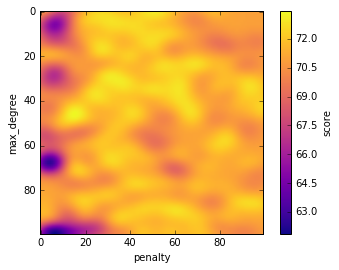

In [ ]:
from sklearn.svm import SVR

k = params[0].keys()

v1 = 'penalty'
v2 = 'max_degree'

xx = []
yy = []
for score, param in zip(scores, params):
    if score > 100:
        continue
    xx.append((param[v1], param[v2]))
    yy.append(score)

xx = np.array(xx, dtype='float32')
yy = np.array(yy, dtype='float32')

model = SVR()
model.fit(xx, yy)
w,h  = 100, 100
xx1, xx2 = np.meshgrid(
     np.linspace(xx[:, 0].min(), xx[:, 0].max(), w),
    np.linspace(xx[:, 1].min(), xx[:, 1].max(), h)
)

xx1 = xx1.flatten()
xx2 = xx2.flatten()
xxs = np.vstack((xx1, xx2)).T
yys = model.predict(xxs)

yys = yys.reshape((w, h))
plt.xlabel(v1)
plt.ylabel(v2)
plt.imshow(yys, cmap='plasma')
plt.colorbar(label='score')
#cm = plt.cm.get_cmap('viridis')
#sc = plt.scatter(xxs[:, 0], xxs[:, 1], cmap=cm, c=yys, s=100, marker='s')
#plt.colorbar(sc)